<a href="https://colab.research.google.com/github/victoryforphil/VictoryCar-UNetModels/blob/master/BerklyLaneDetection_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#pip install keras-tqdm
#!wget https://storage.googleapis.com/victorycar-trainingdata/bdd100k_images.zip
#!wget https://storage.googleapis.com/victorycar-trainingdata/bdd100k_labels_release.zip
#!unzip bdd100k_labels_release.zip
#!unzip bdd100k_images.zip
pip install keras_tqdm

In [3]:
import cv2
import pandas
import numpy as np
import keras
import glob
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as keras
from skimage.draw import line
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback

In [4]:
LABEL_PATH = 'data/input/labels/'
LABEL_VAL_PATH = LABEL_PATH + 'bdd100k_labels_images_val.json'
LABEL_TRAIN_PATH = LABEL_PATH + 'bdd100k_labels_images_train.json'
DATA_PATH_TRAIN = 'data/input/images/train/'
DATA_PATH_VAL = 'data/input/images/val/'
VAL_LOAD = 100
TRAIN_LOAD = 500

In [7]:
def load_label(path, to_load):
  count = 0
  with open(path) as json_file:  
    data = json.load(json_file)
    
    formatted_data = []
    
    for entry in data:
      
      if count > to_load:
        continue
      
      image_name = entry['name']
      labels = entry['labels']
      
      lanes = []
      
      for label in labels:
        cat = label['category']
        if cat not in 'lane':
          continue
          
        polygon = label['poly2d'][0]
        verts  = polygon['vertices']      
        lanes.append(verts)
      
      formatted_data.append([image_name, lanes])
      count += 1
     
    print("Loaded " + str(len(formatted_data)) + " entries")
    return formatted_data
      
val_labels = load_label(LABEL_VAL_PATH, VAL_LOAD)
train_labels = load_label(LABEL_TRAIN_PATH, TRAIN_LOAD)
print(val_labels[1])


Loaded 101 entries
Loaded 501 entries
['b1c81faa-3df17267.jpg', [[[646.69043, 324.704116], [0, 368.614097]], [[1267.418437, 465.748295], [1042.545912, 326.034722]], [[530.927649, 342.66729], [0, 372.605913]], [[527.601134, 345.993804], [0, 381.920151]], [[652.67816, 332.022446], [0, 415.850591]], [[946.076928, 310.732759], [815.012172, 375.932426], [655.339373, 478.389047], [532.923562, 553.568256]], [[561.531603, 559.55598], [691.244546, 478.349211], [820.999901, 376.59773], [952.729962, 318.716392]], [[1029.905147, 322.708208], [1051.860157, 356.638646], [1098.431391, 387.907876], [1280.033212, 516.311303]], [[1277.397987, 535.605082], [1191.548587, 465.043251], [1046.537731, 363.956977], [1019.925598, 324.704116]], [[812.350959, 324.038813], [547.560233, 367.948794], [281.438902, 423.834223], [0, 476.395377]], [[813.016263, 330.026539], [541.572504, 379.924243], [316.034674, 428.491342], [0, 498.348128]]]]


In [9]:
DOWNSCALE = 2

def label_to_image(label):
  lines = label[1]
  image = np.zeros([int(720 / DOWNSCALE),int(1280 / DOWNSCALE),3])
  
  for cur in lines:
    y1 = int(cur[0][0] / DOWNSCALE)
    x1 = int(cur[0][1] / DOWNSCALE)
    y2 = int(cur[1][0] / DOWNSCALE)
    x2 = int(cur[1][1] / DOWNSCALE)
    rr, cc = line(x1,y1,x2,y2)
    rr = np.clip(rr, 0, int(720 / DOWNSCALE) - 2)
    cc = np.clip(cc, 0, int(1280 / DOWNSCALE) -2)
    image[rr     ,cc, :] = 1.0
    image[rr     ,cc - 1, :] = 1.0
    image[rr     ,cc + 1, :] = 1.0
    image[rr - 1 ,cc , :] = 1.0
    image[rr + 1 ,cc , :] = 1.0
    image[rr - 1 ,cc - 1, :] = 1.0
    image[rr + 1 ,cc + 1, :] = 1.0
  image = cv2.resize(image, (254,126))
  return image

y1 = []
for label in train_labels:
  y1.append(label_to_image(label))

y2 = []
for label in val_labels:
  y2.append(label_to_image(label))
  


In [11]:
def load_image(path):
  img = load_img(path)
  
  x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  x = cv2.resize(x, (256,128))
  
  x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
  x = x / 255
  
  return x

def load_images (dir, labels):
  
  images = []
  for label in labels:
    image = label[0]
    path = dir + image
    
    images.append(load_image(path))
    
  return images


  
x1 = load_images(DATA_PATH_TRAIN, train_labels)
x2 = load_images(DATA_PATH_VAL, val_labels)


In [12]:
x1 = np.array(x1)
x2 = np.array(x2)
x1 = x1.reshape(len(x1),128,256,3)
x2 = x2.reshape(len(x2),128,256,3)



W0812 12:06:59.751398 11952 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


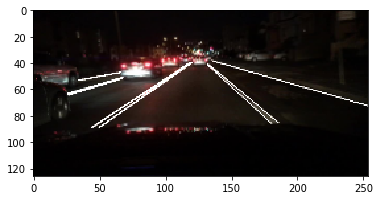

In [15]:
y = y1[50]
x = x1[50]
x = cv2.resize(x, (254,126))
x = np.array([x])
x = x.reshape(len(x),126,254,3)
combined = x[0] + y
plt.imshow(combined)

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return coef

def unet(pretrained_weights = None,input_size = (128,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(3, 3, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 5e-4), loss = 'binary_crossentropy', metrics = [dice_coef])
    
    print(model.summary())

    if(pretrained_weights):
      print('Loading Weights from ' + pretrained_weights)
      model.load_weights(pretrained_weights)

    return model
  
  
model = unet()
model_json = model.to_json()
with open("model-small.json", "w") as json_file:
    json_file.write(model_json)

C:\Users\Victo\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 256, 32) 9248        conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 128, 32)  0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_27 

__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 126, 254, 3)  84          conv2d_47[0][0]                  
Total params: 7,761,015
Trainable params: 7,761,015
Non-trainable params: 0
__________________________________________________________________________________________________
None


1/1 [==============================] - 8s 8s/step


W0812 12:08:46.562825 11952 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


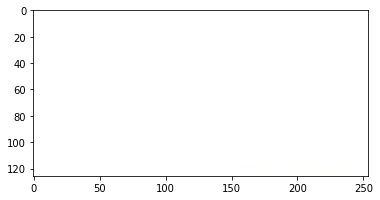

In [21]:
def predict_model():
  test_image = load_image('data/input/images/test/cabc30fc-fd79926f.jpg')
  
  test = np.array([test_image])
  test = test.reshape(len(test),128,256,3)
  lanes = model.predict(test, verbose=1)
 
  y = lanes
  x = cv2.resize(test[0], (254,126))
  x = np.array([x])
  x = x.reshape(len(x),126,254,3)
  combined = x[0] + (y*2)

  
  return combined[0]

plt.imshow(predict_model())

In [ ]:

class Predict(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
      lanes = predict_model()
      plt.imshow(lanes)
      print(lanes.shape)
      plt.savefig('result-' + str(epoch)+'.png')
      return

model_checkpoint = ModelCheckpoint('unet_small.hdf5', monitor='loss',verbose=1, save_best_only=True)

predict_cb = Predict()

from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log',
                         batch_size=4,
                         write_images=True)

model.fit([x1],[y1],validation_data=([x2],[y2]), batch_size=1, epochs=50, verbose=1, shuffle=True, callbacks=[model_checkpoint, predict_cb])

Train on 501 samples, validate on 101 samples
Epoch 1/50
 11/501 [..............................] - ETA: 2:46 - loss: 0.2272 - dice_coef: 7.3898e-1 - ETA: 3:53 - loss: 0.1428 - dice_coef: 1.8065e-1 - ETA: 3:33 - loss: 0.1845 - dice_coef: 1.4132e-1 - ETA: 3:03 - loss: 0.2067 - dice_coef: 1.2134e-1 - ETA: 3:34 - loss: 0.2373 - dice_coef: 1.0641e-1 - ETA: 3:43 - loss: 0.2340 - dice_coef: 1.0153e-1 - ETA: 3:27 - loss: 0.2117 - dice_coef: 1.1793e-1 - ETA: 3:20 - loss: 0.2521 - dice_coef: 1.0711e-1 - ETA: 3:19 - loss: 0.2346 - dice_coef: 1.1490e-1 - ETA: 3:26 - loss: 0.2331 - dice_coef: 1.1104e-1 - ETA: 3:29 - loss: 0.2320 - dice_coef: 1.0786e-10

In [0]:
test_image = load_image('bdd100k/images/10k/test/b432340b-00000000.jpg')
test = np.array([test_image])
test = test.reshape(len(test),128,256,3)
lanes = model.predict(test)
print(lanes.shape)
plt.imshow(test[0])

In [0]:
plt.imshow(lanes[0])

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"